<a href="https://colab.research.google.com/github/tawseeq1/makemore/blob/main/mlp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn.functional as ff
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!git clone https://github.com/karpathy/makemore.git

fatal: destination path 'makemore' already exists and is not an empty directory.


In [4]:
words = open('makemore/names.txt', 'r').read().splitlines()

In [5]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s : i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
block_size = 3
def build_dataset(words):
  X = []
  Y = []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [22]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [71]:
n_emb = 10
n_hidden = 200
g = torch.Generator().manual_seed(266521667)
C = torch.randn((vocab_size, n_emb), generator = g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g) * (5/3) / (n_emb * block_size)**0.5#* 0.1
b1= torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2= torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b1, b2, bngain, bnbias]
for p in parameters:
  p.requires_grad = True

In [72]:
print(sum(p.nelement() for p in parameters))

12297


In [73]:
max_steps = 200000
batch_size  = 32
lossi = []
for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
  emb = C[Xtr[ix]]
  emb_cat = emb.view(emb.shape[0], -1)
  h_u = emb_cat @ W1 +b1
  h_u = (bngain * (h_u - h_u.mean(0, keepdim=True)) / h_u.std(0, keepdim=True)) + bnbias
  h = torch.tanh(h_u)

  logits = h @ W2 + b2
  loss = ff.cross_entropy(logits, Ytr[ix])

  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  lossi.append(loss.log10().item())
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  #break

      0/ 200000: 3.7171
  10000/ 200000: 2.6532
  20000/ 200000: 2.2987
  30000/ 200000: 2.1544
  40000/ 200000: 2.0442
  50000/ 200000: 2.5134
  60000/ 200000: 2.0040
  70000/ 200000: 2.1013
  80000/ 200000: 2.1965
  90000/ 200000: 2.5786
 100000/ 200000: 2.1570
 110000/ 200000: 2.1428
 120000/ 200000: 1.9767
 130000/ 200000: 1.9393
 140000/ 200000: 2.1655
 150000/ 200000: 2.1519
 160000/ 200000: 2.1308
 170000/ 200000: 2.2437
 180000/ 200000: 1.8611
 190000/ 200000: 2.1256


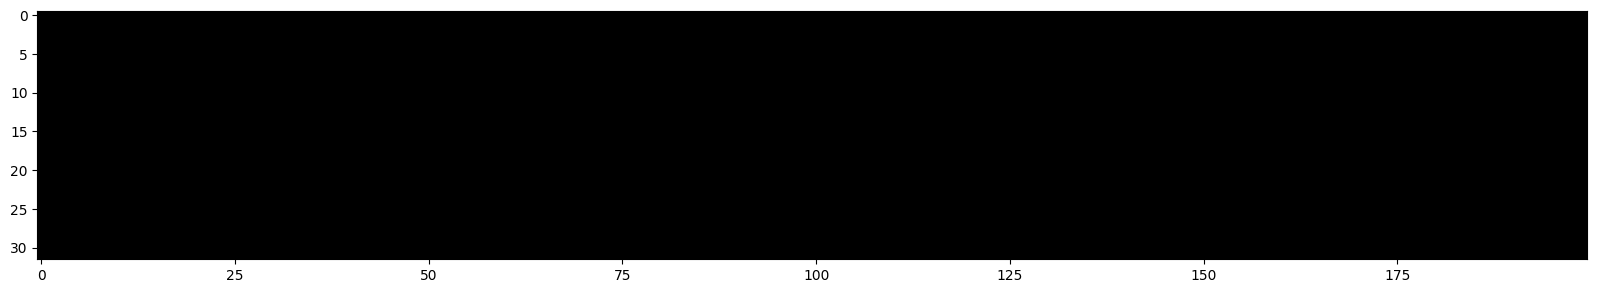

In [53]:
plt.figure(figsize = (20, 10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest')

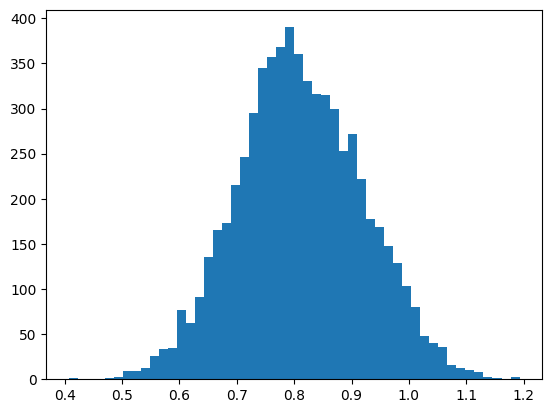

In [54]:
plt.hist(h_u.view(-1).tolist(), 50);

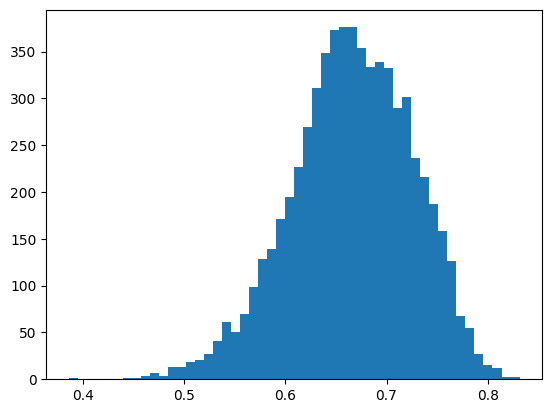

In [55]:
plt.hist(h.view(-1).tolist(), 50);

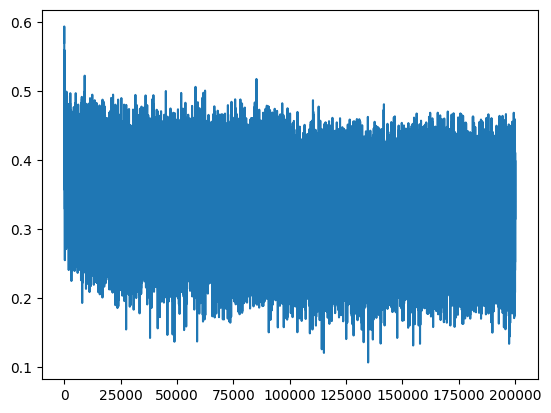

In [74]:
plt.plot(lossi)

In [77]:
with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  h_u = embcat @ W1 +b1
  bnmean = h_u.mean(0, keepdim=True)
  bnstd = h_u.std(0, keepdim=True)

In [78]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte)
  }[split]
  emb = C[x]
  embcat = emb.view(x.shape[0], -1)
  h_u = embcat @ W1 +b1
  h_u = (bngain * (h_u - bnmean) / bnstd) + bnbias
  h = torch.tanh(h_u)
  logits = h @ W2 + b2
  loss = ff.cross_entropy(logits, y)
  print(split, loss.item())
split_loss('train')
split_loss('val')

train 2.070993423461914
val 2.113347053527832


In [81]:
g = torch.Generator().manual_seed(8524517356)
for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    embcat = emb.view(emb.shape[0], -1)
    h_u = embcat @ W1 +b1
    h_u = (bngain * (h_u - bnmean) / bnstd) + bnbias
    h = torch.tanh(h_u)
    logits = h @ W2 + b2
    probs = ff.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

groversen.
kthan.
myrailah.
zandrellieanni.
chanaaria.
kiyah.
nyonne.
jos.
ton.
len.
yuri.
bij.
agud.
hyla.
jana.
nest.
takeizabelia.
abil.
sophanshhanvon.
matalianelle.


Torchified :) code

In [121]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [169]:
class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True

    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)


    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):

    if self.training:
      xmean = x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta


    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

In [170]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [193]:
n_emb = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_emb), generator = g)
# layers = [
#     torch.nn.Linear(n_emb * block_size, n_hidden), Tanh(),
#     torch.nn.Linear(            n_hidden, n_hidden), Tanh(),
#     torch.nn.Linear(            n_hidden, n_hidden), Tanh(),
#     torch.nn.Linear(            n_hidden, n_hidden), Tanh(),
#     torch.nn.Linear(            n_hidden, n_hidden), Tanh(),
#     torch.nn.Linear(          n_hidden, vocab_size),
# ]
layers = [
  Linear(n_emb * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]


In [195]:
with torch.no_grad():
  layers[-1].gamma *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

In [196]:
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

47024


In [197]:
max_steps = 200000
lossi = []
batch_size = 32
ud = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb , Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)

    for layer in layers:
      x = layer(x)

    loss = ff.cross_entropy(x, Yb)

    for layer in layers:
      layer.out.retain_grad()

    for p in parameters:
      p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
      p.data += -lr * p.grad

    if i % 10000 == 0:
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
      ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    break

      0/ 200000: 3.2974


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 3.47%
layer 5 (      Tanh): mean -0.00, std 0.63, saturated: 3.12%
layer 8 (      Tanh): mean +0.01, std 0.63, saturated: 2.88%
layer 11 (      Tanh): mean -0.00, std 0.63, saturated: 2.66%
layer 14 (      Tanh): mean +0.00, std 0.63, saturated: 2.84%


Text(0.5, 1.0, 'activation distribution')

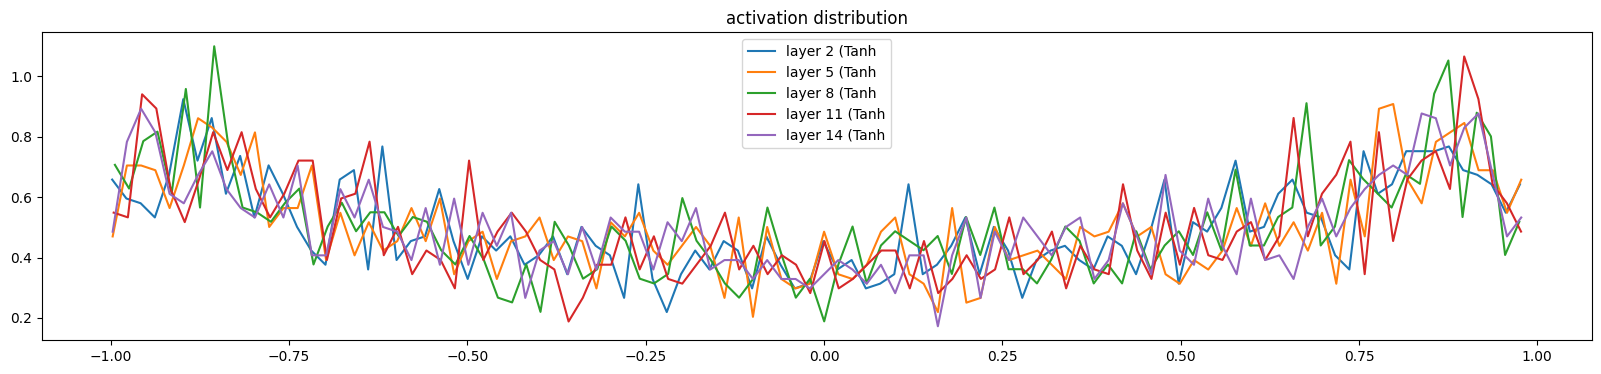

In [198]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 8.470688e-05
layer 5 (      Tanh): mean +0.000000, std 7.271308e-05
layer 8 (      Tanh): mean +0.000000, std 6.805237e-05
layer 11 (      Tanh): mean +0.000000, std 5.864754e-05
layer 14 (      Tanh): mean +0.000000, std 4.960830e-05


Text(0.5, 1.0, 'gradient distribution')

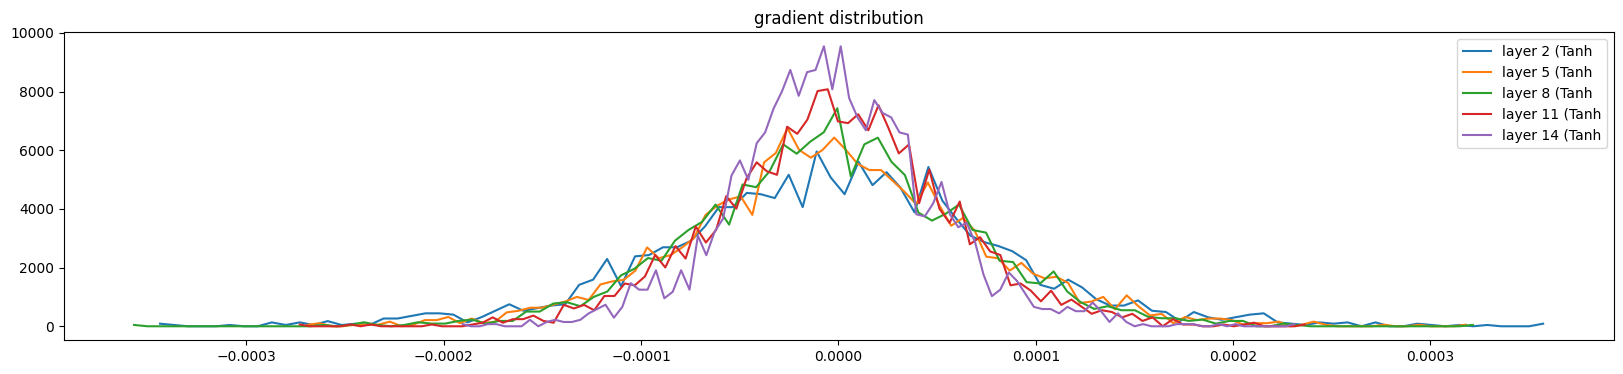

In [199]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 2.052769e-04 | grad:data ratio 2.051284e-04
weight  (30, 100) | mean -0.000001 | std 1.148972e-04 | grad:data ratio 2.210528e-04
weight (100, 100) | mean +0.000003 | std 1.066532e-04 | grad:data ratio 3.852142e-04
weight (100, 100) | mean -0.000000 | std 9.135653e-05 | grad:data ratio 3.264987e-04
weight (100, 100) | mean -0.000001 | std 8.606090e-05 | grad:data ratio 3.088652e-04
weight (100, 100) | mean +0.000000 | std 7.496171e-05 | grad:data ratio 2.687704e-04
weight  (100, 27) | mean +0.000001 | std 1.335153e-04 | grad:data ratio 4.861463e-04


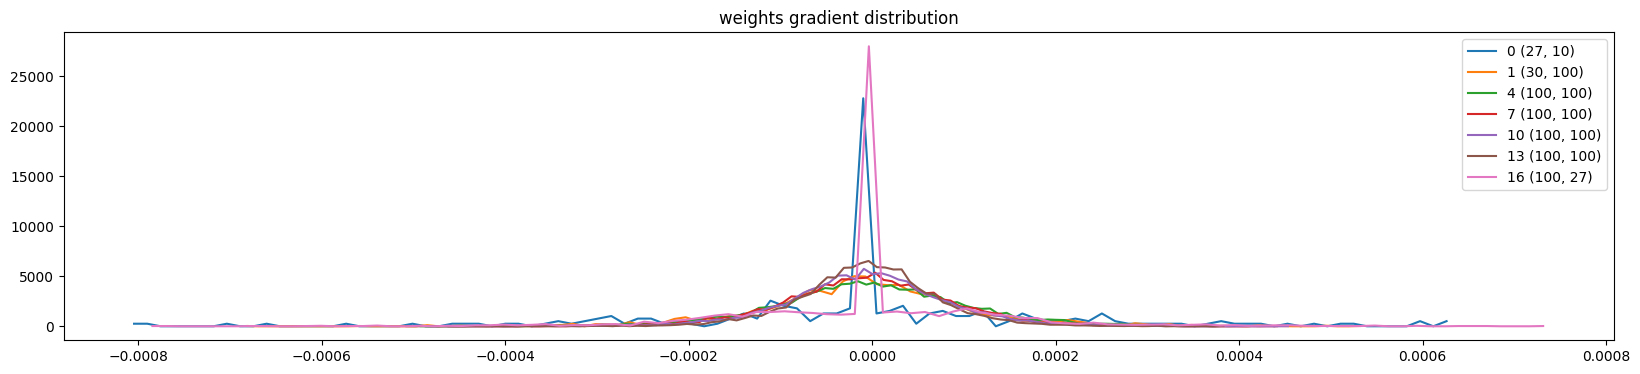

In [200]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

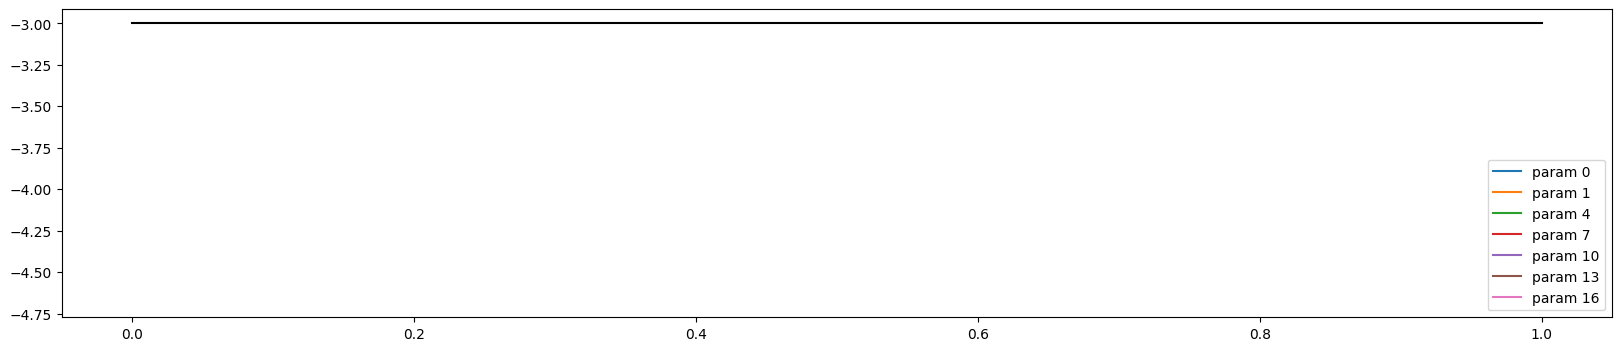

In [201]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);